# Simulation of Complex Systems - Chapter 5

Artur Gasparyan

## Exercise 5.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
n_steps = 1000
n_walks = 10000
sim_size = n_walks, n_steps

rng = np.random.default_rng()

outcomes_bernoulli = rng.choice([-1, 1], sim_size)
outcomes_gaussian = rng.normal(size=sim_size)
outcomes_asymmetry = rng.choice(
    [-1, (1-math.sqrt(3))/2, (1+math.sqrt(3))/2], size=sim_size
)

outcomes_all = outcomes_bernoulli, outcomes_gaussian, outcomes_asymmetry
trajectories_all = tuple(np.cumsum(o, axis=1) for o in outcomes_all)

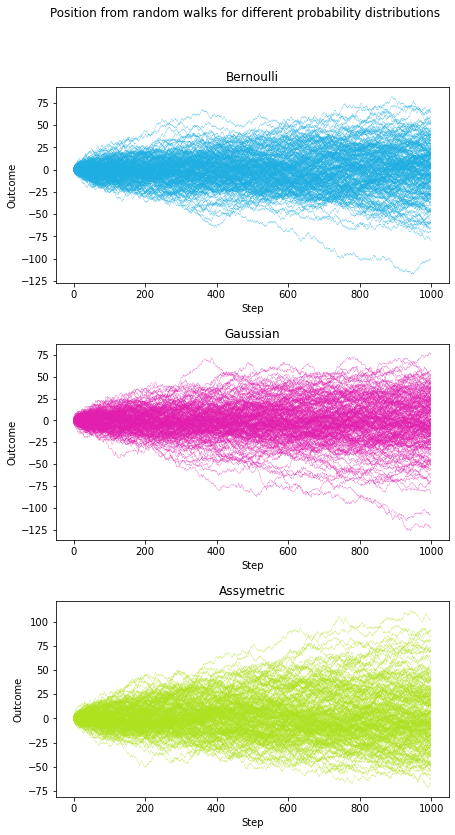

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12))
fig.suptitle("Position from random walks for different probability distributions")
titles = ["Bernoulli", "Gaussian", "Assymetric"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for trajectory, axis, title, color in zip(trajectories_all, axes, titles, colors):
    axis.plot(np.arange(n_steps), trajectory[:200].T, linewidth=0.25, color=color);
    axis.set_xlabel("Step")
    axis.set_ylabel("Outcome")
    axis.set_title(title)
    


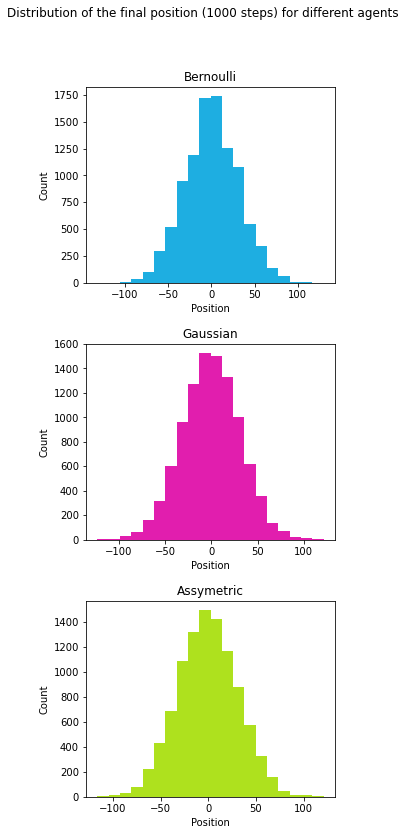

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(5, 12))
fig.suptitle("Distribution of the final position (1000 steps) for different agents")
titles = ["Bernoulli", "Gaussian", "Assymetric"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for trajectory, axis, title, color in zip(trajectories_all, axes, titles, colors):  
    axis.hist(trajectory[:, -1], 20, color=color)
    axis.set_xlabel("Position")
    axis.set_ylabel("Count")
    axis.set_title(title)

## Exercise 5.2

In [5]:
time = 5
n_walks = 50
time_steps = [0.01, 0.05, 0.10]


def get_white_noise_trajectory(nz_walks, time_step):
    n_steps = int(time/time_step)
    trajectory = np.cumsum(rng.normal(size=(n_walks, n_steps)), axis=1)
    return trajectory


trajectories_wn = [get_white_noise_trajectory(n_walks, time_step) for time_step in time_steps]

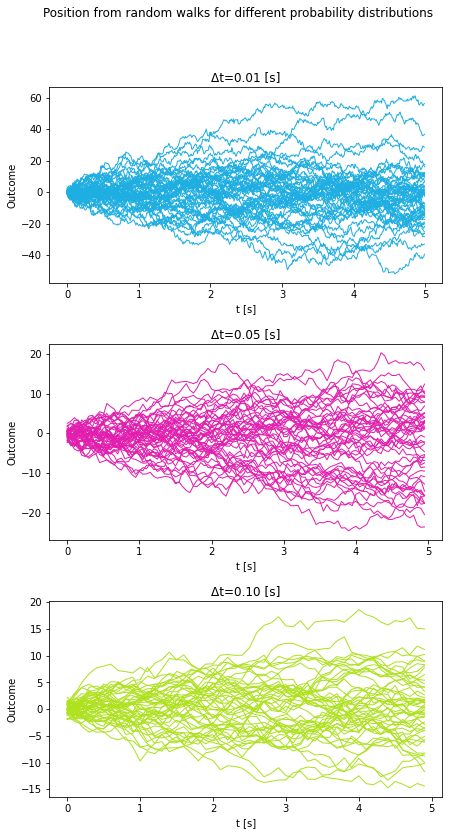

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12))
fig.suptitle("Position from random walks for different probability distributions")
titles = ["Δt=0.01 [s]", "Δt=0.05 [s]", "Δt=0.10 [s]"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for trajectory, time_step, axis, title, color in zip(trajectories_wn, time_steps, axes, titles, colors):
    t = np.arange(int(time/time_step))*time_step
    axis.plot(t, trajectory.T, linewidth=1, color=color);
    axis.set_xlabel("t [s]")
    axis.set_ylabel("Outcome")
    axis.set_title(title)


In [7]:
n_walks = 10000
trajectories_wnl = [get_white_noise_trajectory(n_walks, time_step) for time_step in time_steps]
msd_wnl = [np.mean(traj**2, axis=0) for traj in trajectories_wnl]

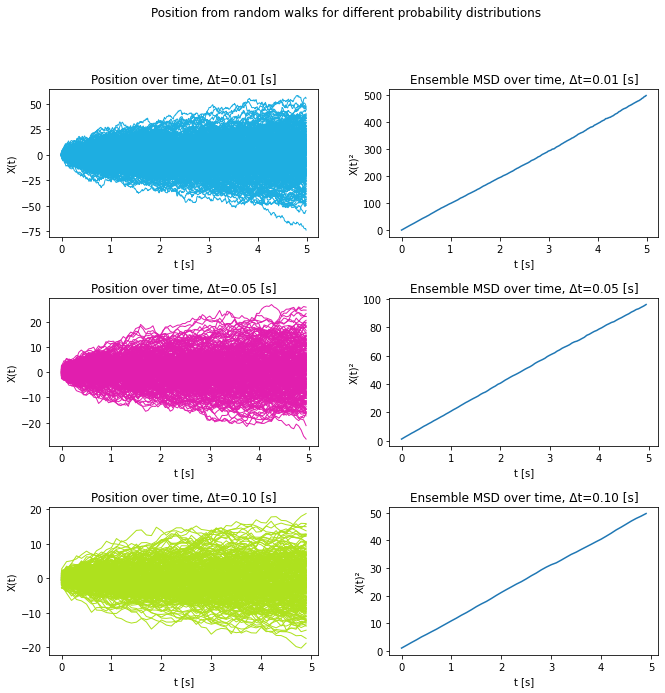

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Position from random walks for different probability distributions")
titles = ["Δt=0.01 [s]", "Δt=0.05 [s]", "Δt=0.10 [s]"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for (
    trajectory, msd, time_step, axis_hi, axis_lo, title, color
) in zip(
    trajectories_wnl, msd_wnl, time_steps, axes[:, 0], axes[:, 1], titles, colors
):
    t = np.arange(int(time/time_step))*time_step
    
    axis_hi.plot(t, trajectory[:300].T, linewidth=1, color=color);
    axis_hi.set_title(f"Position over time, {title}")
    axis_hi.set_xlabel("t [s]")
    axis_hi.set_ylabel("X(t)")

    axis_lo.plot(t, msd)
    axis_lo.set_title(f"Ensemble MSD over time, {title}")
    axis_lo.set_xlabel("t [s]")
    axis_lo.set_ylabel("X(t)²")
    

